# ACT Optimization Visualizations

Note: The figures may different from those reported, depnding on random seed setting.

### Optimization algorithm comparison

In [1]:
import time
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import optimize
import sys
sys.path.insert(0,'./legacy')
from ACT_functions import ACT, ACT_opt, ACT_greedy, ACT_exhaustive
from ACT_tools import *

In [2]:
# Create dataset
N = 256 # length of sample                                                 
t = np.arange(N)                                                           
M = 10 # number of parameters per sets                                     
max_fqcy = 2*np.pi                                                         
c = np.arange(M)*max_fqcy/(2*N*M)                                          
w0 = np.arange(M)*max_fqcy/(2*M)                                           
                                                                           
dataset = np.zeros((M*M, N+2))                                             
for m in range(M*M):                                                       
    c_m = c[m%M]                                                           
    w0_m = w0[m//M] # change w0 every M samples                            
    dataset[m][:-2] = np.sin((c_m*t+w0_m)*t) + np.random.normal(0, 0.05, N)
    dataset[m][-2] = c_m
    dataset[m][-1] = w0_m

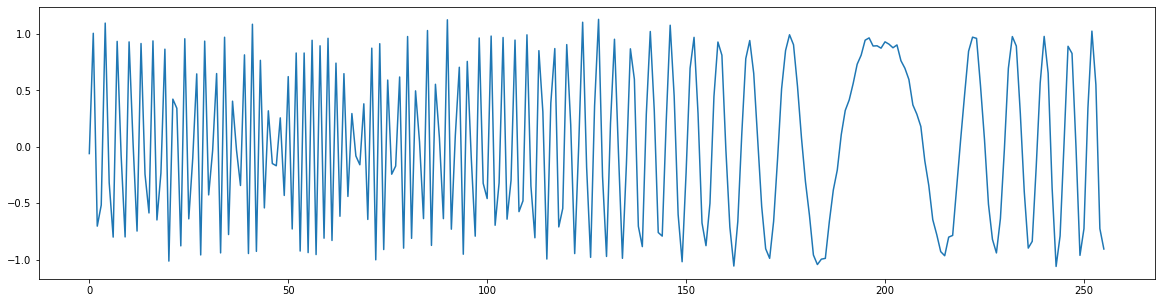

In [3]:
plt.figure(figsize=(20,5))
plt.plot(t, dataset[np.random.randint(0,100),:-2])

Definitions of additional methods

In [4]:
class ACT_MP(ACT):
    '''
    ACT with Matching Pursuit
    Example usage: `ACT_MP.fit(data,P=10)`
    '''
    @classmethod
    def fit(cls, f, P, max_iter_GD = 1000):
        N = len(f)
        _t = np.arange(N)
        i0 = 1
        a = 2
        gamma = np.arange(N+1)
        T = N
        F = 2*np.pi
        D = int(0.5*np.log(N)/np.log(a))
        k = np.arange(D-i0+1)
        m_k = 4*np.power(a, 2*k)-1
        m = [np.arange(mk) for mk in m_k]

        tc = gamma
        wc = (2*np.pi/N)*gamma
        c = [[F*m[k_][i]/(T*np.power(a, 2*k_)) for i in range(m_k[k_])] for k_ in k]
        dt = np.power(a, 2*k)

        start_time = time.time()

        R = [f]
        I = cls.get_Imax(R[-1])
        I_list = [I]

        sum_ = np.multiply(np.power(np.abs(cls.gaussian_chirlet_transform(f, I)), 2), cls.WVgI(I,len(f)))

        for n in range(1, P):
            R.append(R[-1]-np.multiply(cls.gaussian_chirlet_transform(f, I), cls.gaussian_chirplet(_t, I)))
            I = cls.get_Imax(R[-1])
            I_list.append(I)
            plt.figure(figsize=(20,2))
            plt.plot(np.linspace(0, len(f), len(f)), np.real(R[-1]))
            plt.show()

            sum_ = np.add(sum_, np.multiply(np.power(np.abs(cls.gaussian_chirlet_transform(f, I)), 2), cls.WVgI(I,len(f))))

        print("time elapsed: {:.2f}s".format(time.time() - start_time))

        return sum_, I_list
    
    @classmethod
    def get_Imax(cls, Rnf):
        N = len(Rnf)
        _tc, _wc, _c, _dt = N/2, 0.5, 0.001, N/10
        _t = np.arange(N)
        
        def objective(I, args):
            Rnf = args[0]
            g = np.real(cls.gaussian_chirplet(_t, I))
            _Rnf = Rnf/(2*Rnf.std())
            res = -np.dot(_Rnf,g)
            return res
        
        res = minimize(objective, x0 = np.array([_tc,_wc,_c,_dt]), args=[Rnf], method='Nelder-Mead',
                       options={'fatol': 1e-10})
        
        return res.x

In [5]:
def ACT_steve(f, P, max_iter=500):

    def chrip(f_start, f_end, length, tc=0):
        t = np.arange(length)-tc
        c = (f_end-f_start)/length
        wc = c*tc + f_start

        return np.exp(2.j*np.pi*(c*t+wc)*t)

    def similarity_chirp(f, f_start, f_end):
        return np.abs(np.vdot(f, chrip(f_start, f_end, len(f), tc=0)))

    def maximize_similarity(f, max_iter = 50, starting_frequencies=[-0.01, 0, 0.01], ending_frequencies=[-0.03, -0.04, -0.05]):

        f = np.array(f)
        f = f-np.mean(f)

        for iter in range(max_iter):

            #Find the worst parameters to eliminate them:
            index = np.argmin([similarity_chirp(f, starting_frequencies[0], ending_frequencies[1]),
                               similarity_chirp(f, starting_frequencies[1], ending_frequencies[1]),
                               similarity_chirp(f, starting_frequencies[2], ending_frequencies[1])])

            if index == 0:
                starting_frequencies = [starting_frequencies[1], starting_frequencies[2],
                                        2*starting_frequencies[2] - starting_frequencies[1]]
            else:
                starting_frequencies = [max(2*starting_frequencies[0] - starting_frequencies[1], 0),
                                        starting_frequencies[0], starting_frequencies[1]]

            index = np.argmin([similarity_chirp(f, starting_frequencies[1], ending_frequencies[0]),
                               similarity_chirp(f, starting_frequencies[1], ending_frequencies[1]),
                               similarity_chirp(f, starting_frequencies[1], ending_frequencies[2])])

            if index == 0:
                ending_frequencies = [ending_frequencies[1], ending_frequencies[2],
                                      2*ending_frequencies[2] - ending_frequencies[1]]
            else:
                ending_frequencies = [max(2*ending_frequencies[0] - ending_frequencies[1], 0),
                                      ending_frequencies[0], ending_frequencies[1]]

            #Compress inwards
            if iter%2 == 0:
                starting_frequencies = [0.5*(starting_frequencies[0] + starting_frequencies[1]),
                                        starting_frequencies[1],
                                        0.5*(starting_frequencies[1] + starting_frequencies[2])]
                ending_frequencies = [0.5*(ending_frequencies[0] + ending_frequencies[1]),
                                        ending_frequencies[1],
                                        0.5*(ending_frequencies[1] + ending_frequencies[2])]

        return starting_frequencies[1], ending_frequencies[1], similarity_chirp(f, starting_frequencies[1], ending_frequencies[1])

    start_time = time.time()

    starting_frequencies = [0, 0.125, 0.25]
    ending_frequencies = [0, 0.125, 0.25]

    R = [f]
    f_start, f_end, similarity = maximize_similarity(R[-1], max_iter=max_iter, starting_frequencies=starting_frequencies, ending_frequencies=ending_frequencies)
    I_list = [(f_start, f_end)]

    for n in range(1, P):
        R.append(R[-1] - similarity * chrip(f_start, f_end, len(R[-1]), tc=0))
        f_start, f_end, similarity = maximize_similarity(R[-1], max_iter=max_iter, starting_frequencies=starting_frequencies, ending_frequencies=ending_frequencies)
        I_list.append((f_start, f_end))

    print("time elapsed: {:.2f}s".format(time.time() - start_time))

    def sort_act(I_list, f):
        sorted = []
        act_gains = [similarity_chirp(f, f_start, f_end) for (f_start, f_end) in I_list]
        while act_gains:
            j = np.argmax(act_gains)
            sorted.append(I_list[j])
            I_list.pop(j)
            act_gains.pop(j)

        return sorted

    return sort_act(I_list, f), time.time() - start_time

In [6]:
def chirp(t, tc, wc, c):
    return np.exp(1.j*(c*(t-tc)+wc)*(t-tc))

In [7]:
def obj(I,args):
    f = args[0]
    trajectory = args[1]
    t = np.arange(len(f))
    wc, c = I
    g = np.imag(chirp(t, 0, wc*np.pi, c*np.pi/len(f)))
    res = -np.dot(f,g)
    trajectory.append([I])
    return res
def jacobian(I,args):
    f = args[0]
    trajectory = args[1]
    t = np.arange(len(f))
    wc, c = I
    dgdc = -np.dot(f,np.real(chirp(t, 0, wc*np.pi, c*np.pi/len(f)))*np.pi/len(f)*t**2)
    dgdwc = -np.dot(f,np.real(chirp(t, 0, wc*np.pi, c*np.pi/len(f)))*np.pi*t)
    return np.array([dgdwc,dgdc]).squeeze()
def hessian(I,args):
    f = args[0]
    trajectory = args[1]
    t = np.arange(len(f))
    wc, c = I
    dgdc2 = np.dot(f,np.imag(chirp(t, 0, wc*np.pi, c*np.pi/len(f)))*(np.pi/len(f))**2*t**4)
    dgdwcdc = np.dot(f,np.imag(chirp(t, 0, wc*np.pi, c*np.pi/len(f)))*np.pi**2/len(f)*t**3)
    dgdcdwc = np.dot(f,np.imag(chirp(t, 0, wc*np.pi, c*np.pi/len(f)))*np.pi**2/len(f)*t**3)
    dgdwc2 = np.dot(f,np.imag(chirp(t, 0, wc*np.pi, c*np.pi/len(f)))*np.pi**2*t**2)
    return np.array([[dgdwc2,dgdwcdc],[dgdcdwc,dgdc2]]).squeeze()

In [8]:
## Algorithm comparison

avg_time = np.zeros(3)

error_reg = np.zeros((M,M))
error_greedy = np.zeros((M,M))
error_exhaustive = np.zeros((M,M))
error_vec = np.zeros((M,M))
error_ds = np.zeros((M,M))
error_shgo_newton = np.zeros((M,M))
error_shgo = np.zeros((M,M))
error_shgo_long = np.zeros((M,M))

m = 0
for row in dataset:
    # Extract chirp and chirpiness and starting frequency from the dataset
    f = row[:-2]
    c_m = row[-2]
    w0_m = row[-1]

    # Regular act
    act, t = ACT_opt(f, P=1) # GD version run with one MP level
    # extract chirpiness prediction
    c_m_pred = act[0][2]
    
    avg_time[0] += t/(M*M)

    # Absolute diff between original chirpiness and current
    error = np.abs(c_m - c_m_pred)
    # Normalize
    if c_m == 0:
        error_reg[m%M][m//M] = error/c[1]
    else:
        error_reg[m%M][m//M] = error/c_m

    # Greedy act (coordinate-based linear search?)
    act, t = ACT_greedy(f, P=1)
    c_m_pred = act[0][2]
    avg_time[1] += t / (M * M)

    error = np.abs(c_m - c_m_pred)
    if c_m == 0:
        error_greedy[m % M][m // M] = error / c[1]
    else:
        error_greedy[m % M][m // M] = error / c_m

    # Exhaustive act
    act, t = ACT_exhaustive(f, P=1)
    c_m_pred = act[0][2]
    avg_time[2] += t / (M * M)

    error = np.abs(c_m - c_m_pred)
    if c_m == 0:
        error_exhaustive[m % M][m // M] = error / c[1]
    else:
        error_exhaustive[m % M][m // M] = error / c_m
    
    # Nelder-Mead
    act, I = ACT_MP.fit(f, P=1) # GD version run with one MP level
    # extract chirpiness prediction
    c_m_pred = I[0][2]
    # Absolute diff between original chirpiness and current
    error = np.abs(np.abs(c_m) - np.abs(c_m_pred))
    # Normalize
    if c_m == 0:
        error_vec[m%M][m//M] = error/c[1]
    else:
        error_vec[m%M][m//M] = error/c_m
        
    # Dichotomic search
    act, t = ACT_steve(f, P=1)
    c_m_pred = (act[0][1]-act[0][0])/len(f)
    # Absolute diff between original chirpiness and current
    error = np.abs(np.abs(c_m) - np.abs(c_m_pred))
    # Normalize
    if c_m == 0:
        error_ds[m%M][m//M] = error/c[1]
    else:
        error_ds[m%M][m//M] = error/c_m
        
    # SHGO - Newton
    res = optimize.shgo(obj, args=[[f,[]]], bounds=[[0,1],[0,1]], 
                sampling_method='sobol', n=100, iters=10,
                minimizer_kwargs={'method': 'Newton-CG',
                                  'jac': jacobian,
                                  'hess': hessian,
                                  'args': [f,[]]})
    c_m_pred = res.x[1]*max_fqcy/(2*N)
    # Absolute diff between original chirpiness and current
    error = np.abs(np.abs(c_m) - np.abs(c_m_pred))
    
    # Normalize
    if c_m == 0:
        error_shgo_newton[m%M][m//M] = error/c[1]
    else:
        error_shgo_newton[m%M][m//M] = error/c_m
        
    # SHGO - SLSQP - short
    res = optimize.shgo(obj, args=[[f,[]]], bounds=[[0,1],[0,1]], 
                    sampling_method='sobol', n=100, iters=20,
                    minimizer_kwargs={'method': 'SLSQP', 'jac': jacobian, 'args':[f,[]], 'xtol': 1e-30})
    c_m_pred = res.x[1]*max_fqcy/(2*N)
    # Absolute diff between original chirpiness and current
    error = np.abs(np.abs(c_m) - np.abs(c_m_pred))
    
    # Normalize
    if c_m == 0:
        error_shgo[m%M][m//M] = error/c[1]
    else:
        error_shgo[m%M][m//M] = error/c_m
    
    # SHGO - SLSQP - long
    res = optimize.shgo(obj, args=[[f,[]]], bounds=[[0,1],[0,1]], 
                    sampling_method='sobol', n=100, iters=100,
                    minimizer_kwargs={'method': 'SLSQP', 'jac': jacobian, 'args':[f,[]], 'xtol': 1e-30})
    c_m_pred = res.x[1]*max_fqcy/(2*N)
    # Absolute diff between original chirpiness and current
    error = np.abs(np.abs(c_m) - np.abs(c_m_pred))
    
    # Normalize
    if c_m == 0:
        error_shgo_long[m%M][m//M] = error/c[1]
    else:
        error_shgo_long[m%M][m//M] = error/c_m
        
    print(m)
    m += 1

print("Average computation time:", avg_time)

error_reg = np.mean(error_reg, axis=1)
error_greedy = np.mean(error_greedy, axis=1)
error_exhaustive = np.mean(error_exhaustive, axis=1)
error_vec = np.mean(error_vec, axis=1)
error_ds = np.mean(error_ds, axis=1)
error_shgo = np.mean(error_shgo, axis=1)
error_shgo_newton = np.mean(error_shgo_newton, axis=1)
error_shgo_long = np.mean(error_shgo_long, axis=1)

time elapsed: 0.87s
time elapsed: 0.03s
time elapsed: 1.70s
time elapsed: 0.09s
time elapsed: 0.16s
0
time elapsed: 0.38s
time elapsed: 0.03s
time elapsed: 1.67s
time elapsed: 0.14s
time elapsed: 0.16s
1
time elapsed: 0.65s
time elapsed: 0.06s
time elapsed: 1.65s
time elapsed: 0.10s
time elapsed: 0.16s
2
time elapsed: 0.40s
time elapsed: 0.04s
time elapsed: 1.83s
time elapsed: 0.12s
time elapsed: 0.18s
3
time elapsed: 0.78s
time elapsed: 0.03s
time elapsed: 1.65s
time elapsed: 0.13s
time elapsed: 0.17s
4
time elapsed: 0.94s
time elapsed: 0.03s
time elapsed: 1.66s
time elapsed: 0.10s
time elapsed: 0.16s
5
time elapsed: 0.06s
time elapsed: 0.03s
time elapsed: 1.65s
time elapsed: 0.12s
time elapsed: 0.17s
6
time elapsed: 0.18s
time elapsed: 0.03s
time elapsed: 1.70s
time elapsed: 0.12s
time elapsed: 0.17s
7
time elapsed: 1.13s
time elapsed: 0.03s
time elapsed: 1.69s
time elapsed: 0.11s
time elapsed: 0.16s
8
time elapsed: 0.34s
time elapsed: 0.06s
time elapsed: 1.70s
time elapsed: 0.17s
ti

time elapsed: 0.16s
79
time elapsed: 0.07s
time elapsed: 0.03s
time elapsed: 1.74s
time elapsed: 0.09s
time elapsed: 0.16s
80
time elapsed: 0.45s
time elapsed: 0.03s
time elapsed: 1.69s
time elapsed: 0.12s
time elapsed: 0.17s
81
time elapsed: 0.12s
time elapsed: 0.03s
time elapsed: 1.69s
time elapsed: 0.12s
time elapsed: 0.17s
82
time elapsed: 0.39s
time elapsed: 0.03s
time elapsed: 1.71s
time elapsed: 0.09s
time elapsed: 0.17s
83
time elapsed: 1.46s
time elapsed: 0.07s
time elapsed: 1.72s
time elapsed: 0.11s
time elapsed: 0.17s
84
time elapsed: 0.49s
time elapsed: 0.03s
time elapsed: 1.71s
time elapsed: 0.12s
time elapsed: 0.16s
85
time elapsed: 1.49s
time elapsed: 0.03s
time elapsed: 1.72s
time elapsed: 0.08s
time elapsed: 0.22s
86
time elapsed: 0.83s
time elapsed: 0.03s
time elapsed: 1.71s
time elapsed: 0.09s
time elapsed: 0.17s
87
time elapsed: 1.45s
time elapsed: 0.03s
time elapsed: 1.65s
time elapsed: 0.14s
time elapsed: 0.17s
88
time elapsed: 1.47s
time elapsed: 0.05s
time elaps

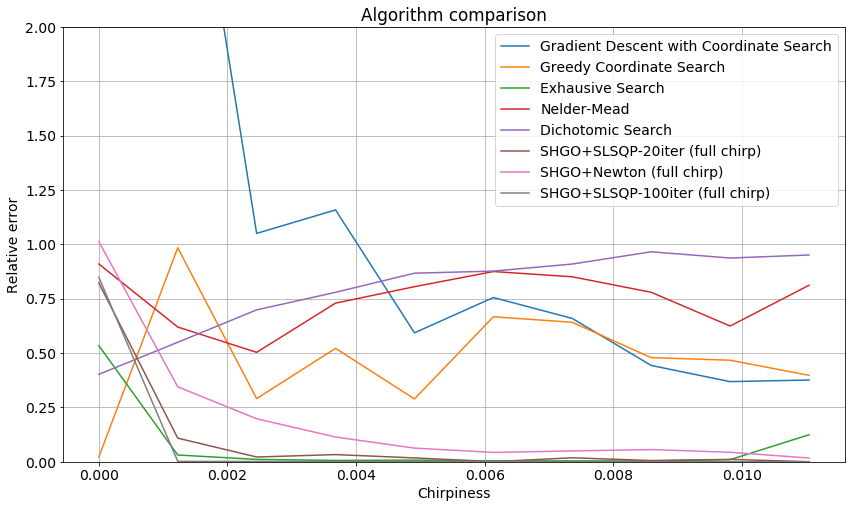

In [14]:
plt.figure(figsize=(14,8))
plt.rcParams['font.size'] = 14
plt.plot(c, error_reg, label="Gradient Descent with Coordinate Search")
plt.plot(c, error_greedy, label="Greedy Coordinate Search")
plt.plot(c, error_exhaustive, label="Exhausive Search")
plt.plot(c, error_vec, label="Nelder-Mead")
plt.plot(c, error_ds, label="Dichotomic Search")
plt.plot(c, error_shgo, label="SHGO+SLSQP-20iter (full chirp)")
plt.plot(c, error_shgo_newton, label="SHGO+Newton (full chirp)")
plt.plot(c, error_shgo_long, label="SHGO+SLSQP-100iter (full chirp)")

plt.xlabel("Chirpiness")
plt.ylabel("Relative error")
plt.title("Algorithm comparison")
plt.legend()
plt.grid()
plt.ylim((0,2))
#plt.savefig("error_vs_c_N" + str(N) + "_M" + str(M) + ".jpg")
plt.show()

### Objective function analysis

In [15]:
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from sobol import *

In [16]:
f = dataset[55][:-2]

def visualize_objective(f, fun=None, wci=None, ci=None, zi=None, opt_trajectory=None, plot_title=None, fig=None):
    N = len(f)                                             
    t = np.arange(N)                                                           
    M = 10 # number of parameters per sets                                     
    max_fqcy = 2*np.pi  
    
    if wci is None or ci is None or zi is None:
        samples = []
        seed = 1234
        for i in range(100000):
            seq, seed = i4_sobol(dim_num = 2, seed = seed)
            samples += [seq]
        samples = np.array(samples)

        _wc, _c = samples[:,0]*max_fqcy/2, samples[:,1]*max_fqcy/(2*N)
        z = [-fun([_wc[i], _c[i]],[f,[]]) for i in range(len(_wc))] # Negate the objective as we're maximizing
        wci, ci = np.meshgrid(np.linspace(0, max_fqcy/2, 1000), np.linspace(0, max_fqcy/(2*N), 1000))
        zi = griddata((_wc, _c), z, (wci, ci), method='nearest', rescale=True)
    if fig is None:
        plt.figure(figsize=(12,10))
    plt.rcParams['font.size'] = 16
    pcm = plt.pcolormesh(wci*N/(2*np.pi), ci*N**2/(2*np.pi), zi, vmin=zi.min(), vmax=zi.max())
    plt.plot(dataset[idx][-1]*N/(2*np.pi),dataset[idx][-2]*N**2/(2*np.pi),'xr',markersize=12, markeredgewidth=2)
    if opt_trajectory is not None:
        plt.plot(opt_trajectory[:,0]*N/(2*np.pi),opt_trajectory[:,1]*N**2/(2*np.pi),'k')
        plt.plot(opt_trajectory[:,0]*N/(2*np.pi),opt_trajectory[:,1]*N**2/(2*np.pi),'xk',markersize=10, markeredgewidth=2)
    plt.xlabel("$f_c\ [Hz]$")
    plt.ylabel("$c\ [Hz^2]$")
    plt.xlim((0,max_fqcy/2*N/(2*np.pi)))
    plt.ylim((0,max_fqcy/(2*N)*N**2/(2*np.pi)))
    plt.title(plot_title)
    plt.gcf().colorbar(pcm)

The old code operated on angles, instead of frequencies. The objective values need to be, thereofre, re-scaled to work with the legacy visualization function. Ideally, all the functions will have to be re-written in the future, but for now we can just use angles for producing visualizations and frequencies for optimization. 

In [17]:
def obj_vis(I,args):
    f = args[0]
    trajectory = args[1]
    t = np.arange(len(f))
    wc, c = I
    g = np.imag(chirp(t, 0, wc, c))
    res = -np.dot(f,g)
    trajectory.append([I])
    return res
def jacobian_vis(I,args):
    f = args[0]
    trajectory = args[1]
    t = np.arange(len(f))
    wc, c = I
    dgdc = -np.dot(f,np.real(chirp(t, 0, wc, c))*t**2)
    dgdwc = -np.dot(f,np.real(chirp(t, 0, wc, c))*t)
    return np.array([dgdwc,dgdc]).squeeze()
def hessian_vis(I,args):
    f = args[0]
    trajectory = args[1]
    t = np.arange(len(f))
    wc, c = I
    dgdc2 = np.dot(f,np.imag(chirp(t, 0, wc, c))*t**4)
    dgdwcdc = np.dot(f,np.imag(chirp(t, 0, wc, c))*t**3)
    dgdcdwc = np.dot(f,np.imag(chirp(t, 0, wc, c))*t**3)
    dgdwc2 = np.dot(f,np.imag(chirp(t, 0, wc, c))*t**2)
    return np.array([[dgdwc2,dgdwcdc],[dgdcdwc,dgdc2]]).squeeze()

**Display a data sample**

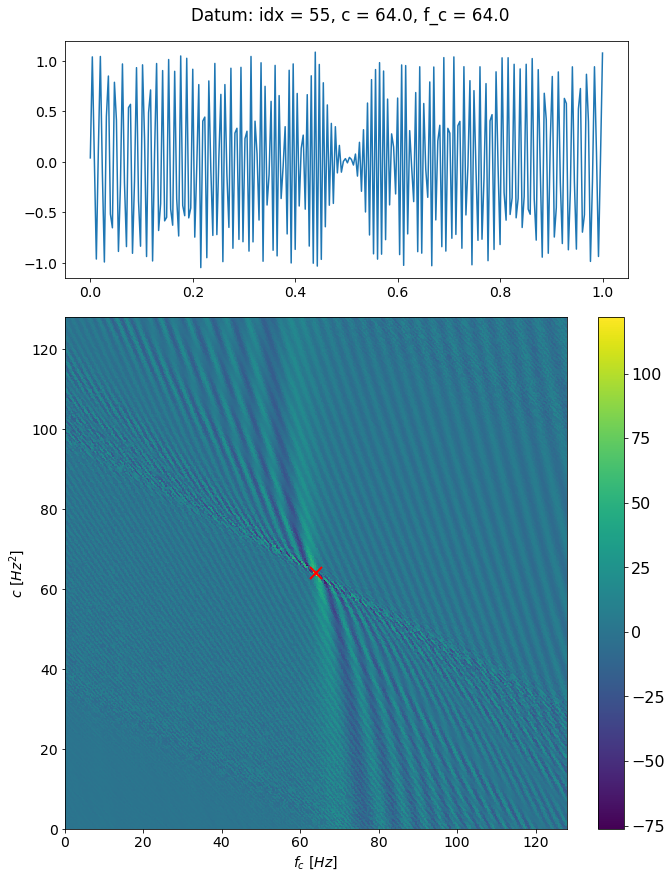

In [18]:
save_data = False
for idx in [55]: # To display just one sample
#for idx in range(len(dataset)): # To save all the data.
    fig = plt.figure(figsize=(10,12))
    #plt.rcParams['font.size'] = 16
    fig.suptitle("Datum: idx = {}, c = {}, f_c = {}".format(idx, dataset[idx][-2]*N**2/(2*np.pi), 
                                                            dataset[idx][-1]*N/(2*np.pi)),y=1.02)
    spec = gridspec.GridSpec(ncols=20, nrows=6)
    top_left_ax = fig.add_subplot(spec[:2, :18])
    bottom_left_ax = fig.add_subplot(spec[2:, :])

    f = dataset[idx][:-2]

    top_left_ax.plot(np.linspace(0,1,len(f)),f,label='Signal')
    
    plt.sca(bottom_left_ax)
    visualize_objective(f, fun=obj_vis, fig=fig)

    fig.tight_layout()
    if save_data:
        fig.savefig('./objective_landscape_viz2/objective_landscape_viz_{:02d}.png'.format(idx),bbox_inches='tight')
        plt.close(fig)

**Trust region optimization**

In [19]:
f = dataset[55][:-2]
N = len(f)
trajectory = []
_wc, _c = 0.1, 0.1
res = minimize(obj, x0 = np.array([_wc,_c]), args=[f,trajectory], bounds=[[0,1],[0,1]], method='trust-constr', jac=jacobian, hess=hessian,
                       options={'gtol':1e-30,'xtol':1e-30,'disp':True,'maxiter':1e20,
                               'initial_constr_penalty':100, 'initial_barrier_parameter': 0.1,
                               'initial_barrier_tolerance':0.1})
trajectory = np.array(trajectory).squeeze()

`xtol` termination condition is satisfied.
Number of iterations: 93, function evaluations: 65, CG iterations: 90, optimality: 2.48e-09, constraint violation: 0.00e+00, execution time: 0.25 s.


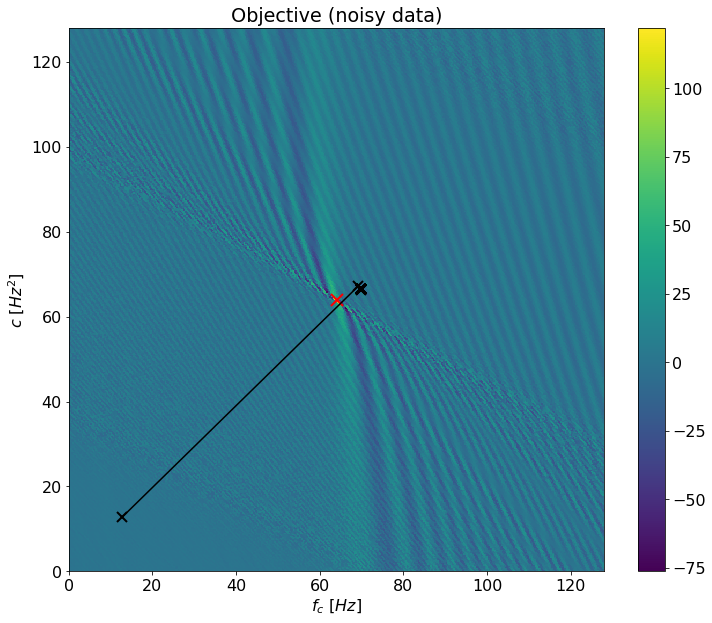

In [20]:
visualize_objective(f, fun=obj_vis,
                    opt_trajectory=trajectory*np.array([max_fqcy/2,max_fqcy/(2*N)]), 
                    plot_title="Objective (noisy data)")

**Jacobian and Hessian**

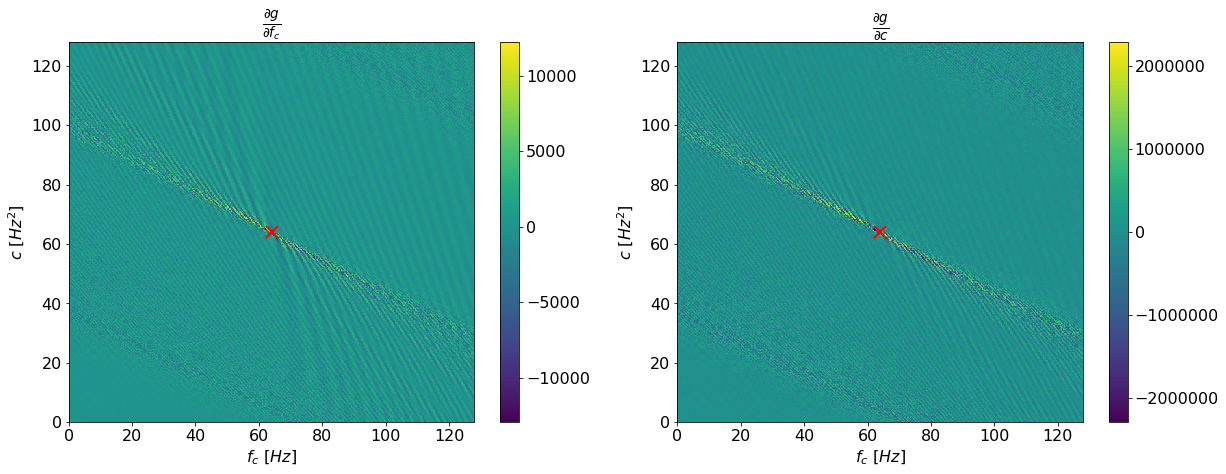

In [21]:
def jac_dgdwc(*args):
    return jacobian_vis(*args)[0]

def jac_dgdc(*args):
    return jacobian_vis(*args)[1]

fig = plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
visualize_objective(f, fun=jac_dgdwc, opt_trajectory=None, plot_title="$\\frac{\\partial g}{\\partial f_c}$", fig=fig)
plt.subplot(1,2,2)
visualize_objective(f, fun=jac_dgdc, opt_trajectory=None, plot_title="$\\frac{\\partial g}{\\partial c}$", fig=fig)

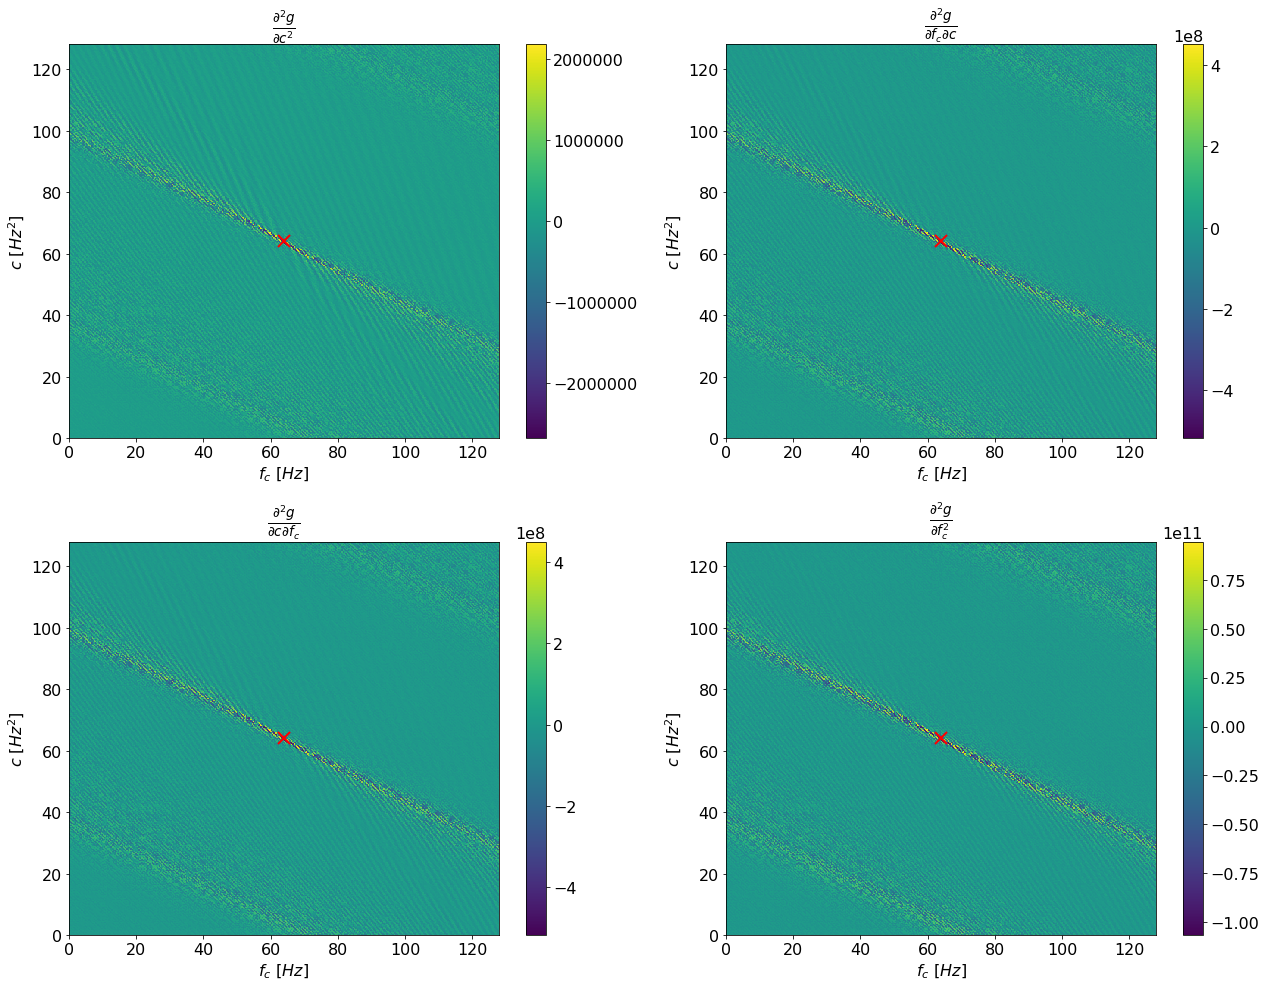

In [23]:
def hess_dgdc2(*args):
    return hessian_vis(*args)[0,0]
def hess_dgdwcdc(*args):
    return hessian_vis(*args)[0,1]
def hess_dgdcdwc(*args):
    return hessian_vis(*args)[1,0]
def hess_dgdwc2(*args):
    return hessian_vis(*args)[1,1]

fig = plt.figure(figsize=(18,14))
plt.subplot(2,2,1)
visualize_objective(f, fun=hess_dgdc2, opt_trajectory=None, plot_title="$\\frac{\\partial^2 g}{\\partial c^2}$", fig=fig)
plt.subplot(2,2,2)
visualize_objective(f, fun=hess_dgdwcdc, opt_trajectory=None, plot_title="$\\frac{\\partial^2 g}{\\partial f_c \\partial c}$", fig=fig)
plt.subplot(2,2,3)
visualize_objective(f, fun=hess_dgdcdwc, opt_trajectory=None, plot_title="$\\frac{\\partial^2 g}{\\partial c \\partial f_c}$", fig=fig)
plt.subplot(2,2,4)
visualize_objective(f, fun=hess_dgdwc2, opt_trajectory=None, plot_title="$\\frac{\\partial^2 g}{\\partial f_c^2}$", fig=fig)
plt.tight_layout()